In [1]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('line_fit.csv')

sigmaG = df['sigmaG']
sigmaL = df['sigmaL']
ampL = df['ampL']
ampG = df['ampG']
width = df['FWHM']
Amp = df['Amp']
cen = df['cen']

filtered_df = df[df['ampL'] > 1e2]
filtered_df.head(8)


,Unnamed: 0,cen,ampG,sigmaG,ampL,sigmaL,FWHM,Amp
0,0,1924.804688,0.0,0.000715,3.290484e+09,0.000715,0.002576,3.290484e+09
1,1,1921.875000,0.0,0.000715,4.088509e+09,0.000715,0.002576,4.088509e+09
2,2,1918.945312,0.0,0.000715,3.338928e+09,0.000715,0.002576,3.338928e+09
3,3,1916.015625,0.0,0.000715,3.291507e+09,0.000715,0.002576,3.291507e+09
4,4,1913.085938,0.0,0.000715,3.275875e+09,0.000715,0.002576,3.275875e+09
5,5,1910.156250,0.0,0.000715,3.297142e+09,0.000715,0.002576,3.297142e+09
6,6,1907.226562,0.0,0.000715,3.292005e+09,0.000715,0.002576,3.292005e+09
7,7,1904.296875,0.0,0.000715,3.302833e+09,0.000715,0.002576,3.302833e+09


/home/long/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


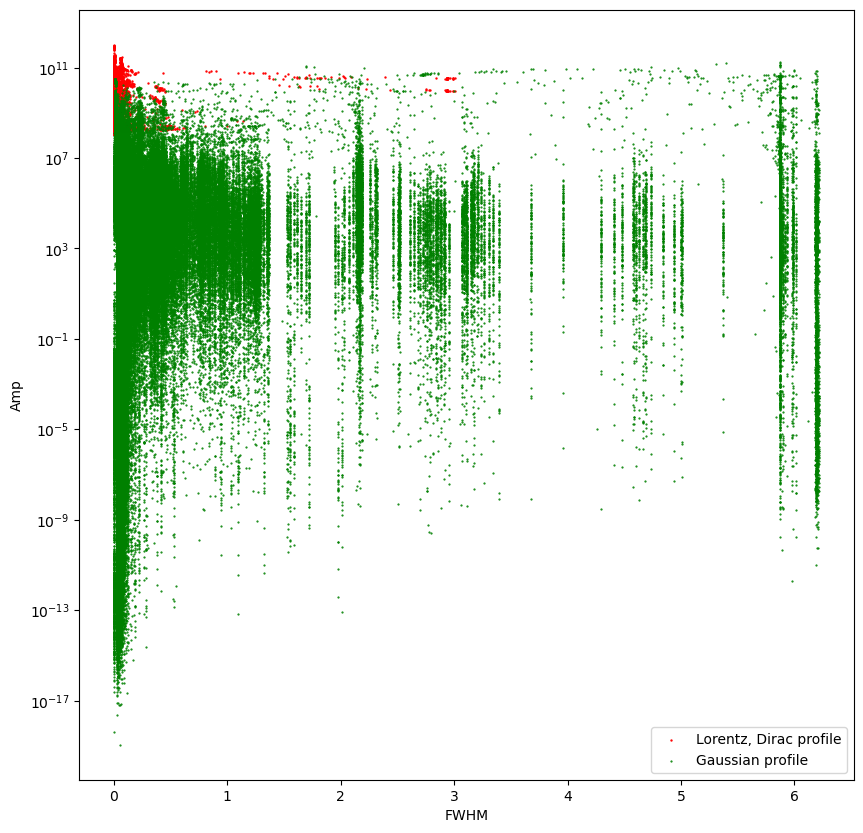

In [3]:
plt.figure(figsize = [10,10])
plt.scatter(sigmaL, ampL, c = 'r', s = 0.5, label = 'Lorentz, Dirac profile')
plt.scatter(sigmaG, ampG, c = 'g', s = 0.3, label = 'Gaussian profile')
plt.legend()
plt.yscale('log')

plt.xlabel('FWHM')
plt.ylabel('Amp')
plt.show()

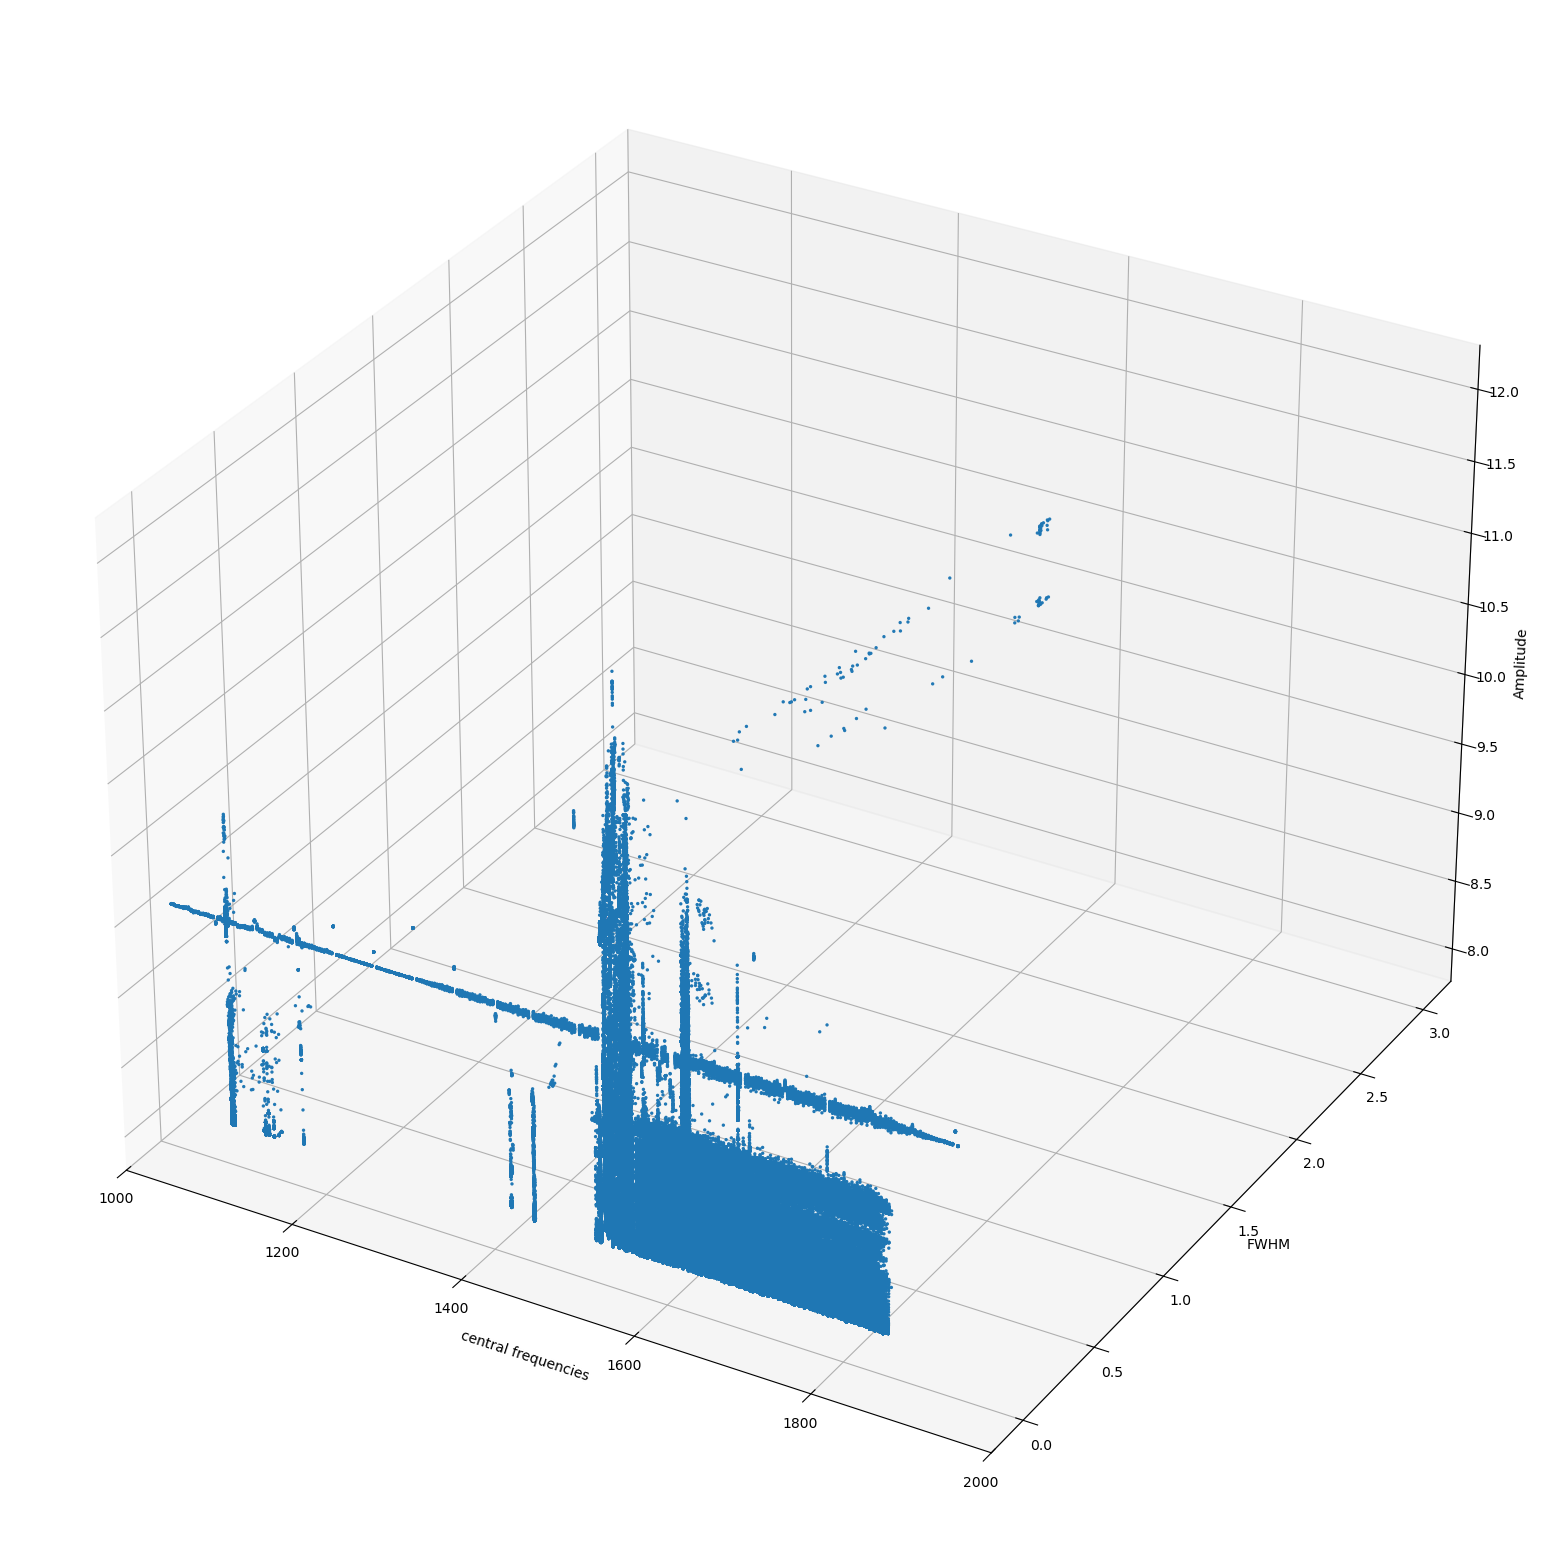

In [4]:
fig = plt.figure(figsize = [20,20])
ax = fig.add_subplot(projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.scatter(filtered_df['cen'], filtered_df['sigmaL'], np.log10(filtered_df['ampL']), s = 2.0)

ax.set_xlabel('central frequencies')
ax.set_zlabel('Amplitude')
ax.set_ylabel('FWHM')

ax.set_xlim(1000,2000)

#ax.set_zscale('log')

plt.show()


In [5]:
cluster_data = filtered_df.drop(columns = ['ampG','sigmaG','Amp','FWHM'])
cluster_data = cluster_data[cluster_data['cen'] < 2000.0]
cluster_data = cluster_data[cluster_data['cen'] > 1000.0]

In [6]:
df = (cluster_data - np.mean(cluster_data, axis=0)) / np.std(cluster_data, axis=0)
df = cluster_data.values

 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 1234975663.0579288
Error treshold: 1769346458.914472


Text(0, 0.5, 'frequency')

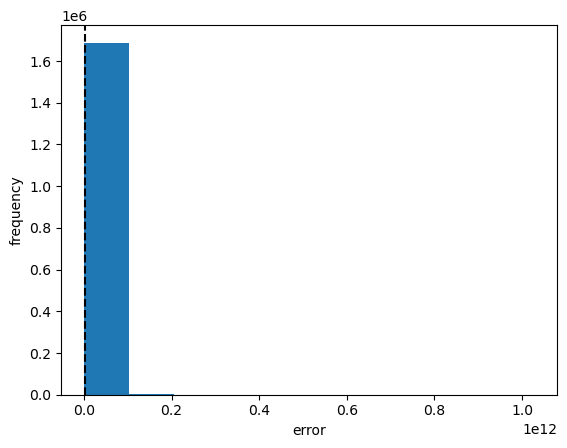

In [7]:
# Initialization and training
som = MiniSom(2, 150, df.shape[1], sigma=1, learning_rate=0.5,
              topology='rectangular', neighborhood_function='gaussian', random_seed=10)


som.train(df, 3000, random_order=False, verbose=True)  # random training

quantization_errors = np.linalg.norm(som.quantization(df) - df, axis=1)
error_treshold = np.percentile(quantization_errors, 95)

print('Error treshold:', error_treshold)

is_outlier = quantization_errors > error_treshold

plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

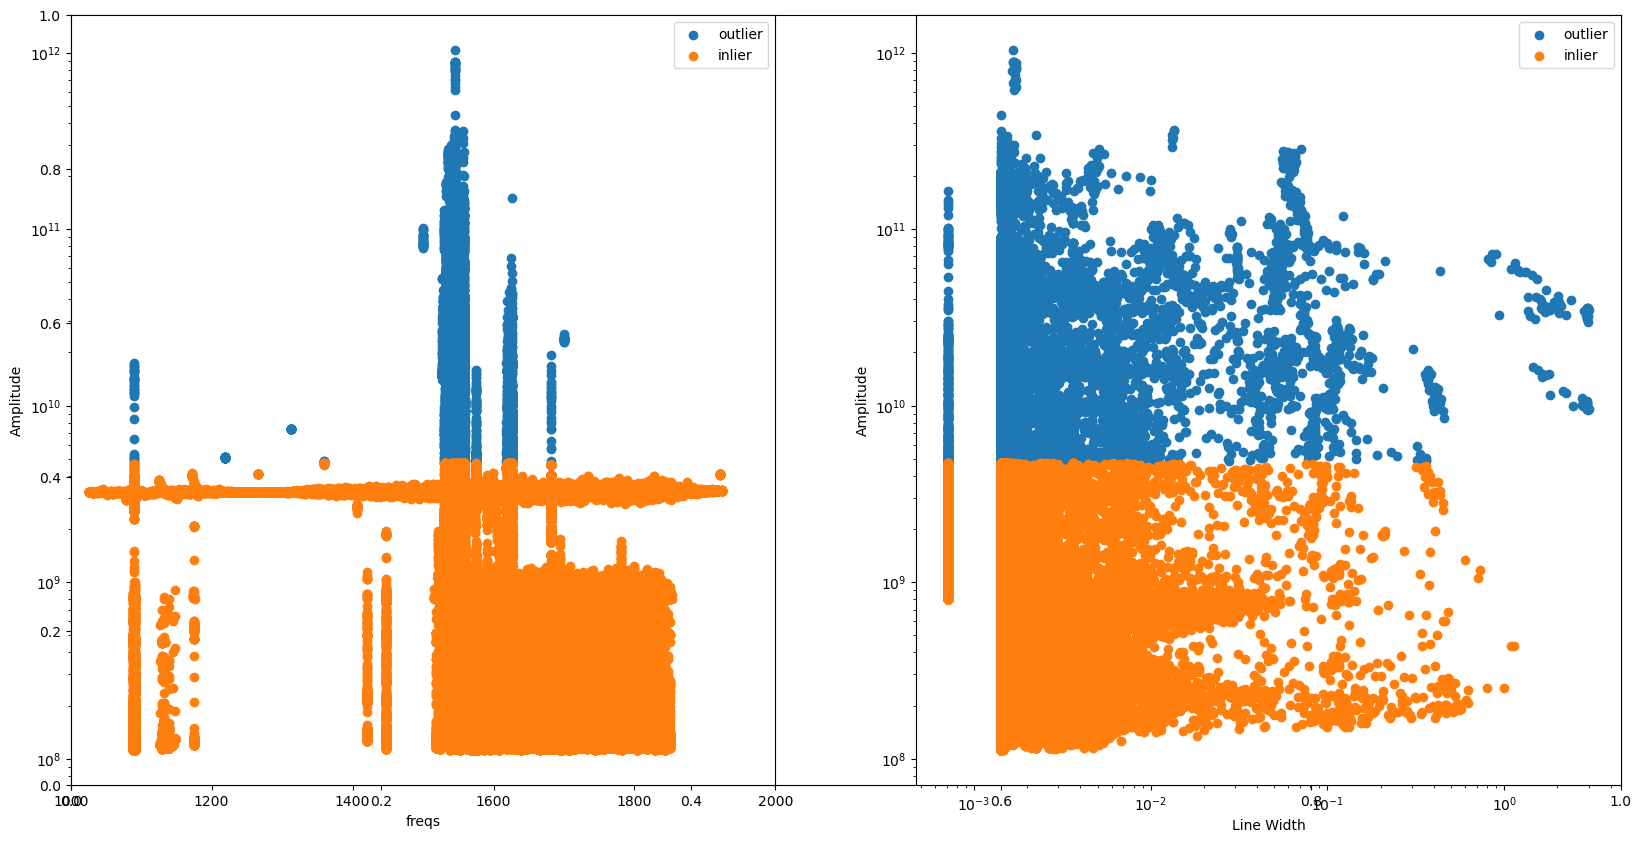

In [8]:
fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot()
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
outlier = cluster_data[is_outlier]
inlier = cluster_data[~is_outlier]


plt.subplot(1,2,1)
plt.scatter(outlier['cen'],outlier['ampL'], label = 'outlier')
plt.scatter(inlier['cen'],inlier['ampL'], label = 'inlier')
plt.xlabel('freqs')
plt.ylabel(r'Amplitude')
plt.yscale('log')
plt.xlim(1000,2000)
plt.legend()

plt.subplot(1,2,2)
plt.scatter(outlier['sigmaL'],outlier['ampL'], label = 'outlier')
plt.scatter(inlier['sigmaL'],inlier['ampL'], label = 'inlier')
plt.xlabel('Line Width')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xscale('log')
plt.legend()

#ax.set_zscale('log')
plt.savefig('SOM.pdf')
plt.show()

In [9]:
print(len(cluster_data), len(outlier), len(inlier))

1690460 84523 1605937


In [10]:
outlier.head(10)

,Unnamed: 0,cen,ampL,sigmaL
24626,24626,1699.999809,2.386130e+10,0.000715
27687,27687,1681.480337,1.091874e+10,0.001515
37383,37383,1625.618534,1.776007e+10,0.006689
37384,37384,1625.622114,5.799624e+09,0.002717
37585,37585,1625.495204,2.528634e+10,0.007785
37586,37586,1625.495141,8.057690e+09,0.007209
37587,37587,1625.505260,8.675982e+09,0.001431
37588,37588,1625.495512,5.732840e+09,0.001431
37589,37589,1625.503489,5.732840e+09,0.001431
37590,37590,1625.494997,5.733041e+09,0.001431


In [11]:
outlier.to_csv('outlier.csv')